# EML01 - Explainable Machine Learning for Signal Processing (Module III of ENGSCI712)

## Example Signal

In [52]:
import warnings
warnings.filterwarnings('ignore')


from dslab.visualization.visualize import distributions

In [67]:
import numpy as np
import pandas as pd

t = pd.date_range(start='2020-09-23 15:00',
                 end='2020-09-23 15:02',
                 periods=120*100+1)
df = pd.DataFrame(index=t)
delta_t = df.index - df.index[0]
df['seconds'] = delta_t.seconds + delta_t.microseconds/1e6
np.random.seed(2020)
df['signal'] = np.sin(df.seconds/10 * 2 *np.pi) + 0.5*np.random.randn(df.shape[0])
idx = np.asarray(np.floor(df.reset_index().index / 100).values, np.int)
df['window_idx'] = ['s{:03}'.format(i) for i in idx]

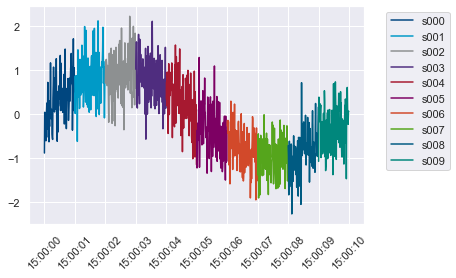

In [3]:
import dslab
import matplotlib.pyplot as plt

def plot_signal(df, n=10):
    for idx in np.unique(df['window_idx'])[:n]:
        plt.plot(df.signal[df.window_idx == idx], label=idx)
        plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
plot_signal(df)

## Define target

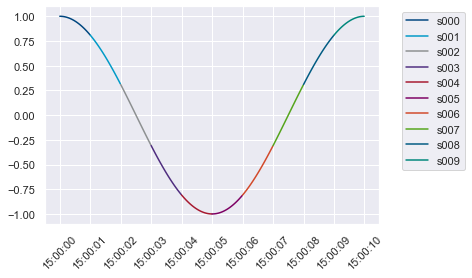

In [4]:
y = df.copy()
y['signal'] = np.cos(df.seconds/10 * 2 *np.pi)
plot_signal(y)

# Regression problem

In [5]:
y_reg = y.groupby('window_idx').signal.mean()[:-1] 
y_reg

window_idx
s000    0.936441
s001    0.580662
s002    0.003090
s003   -0.575662
s004   -0.934531
          ...   
s115   -0.936441
s116   -0.580662
s117   -0.003090
s118    0.575662
s119    0.934531
Name: signal, Length: 120, dtype: float64

In [6]:
reg_target = pd.merge(y_reg.reset_index(), y, on='window_idx')
reg_target.index = y[:-1].index
reg_target.head()

,window_idx,signal_x,seconds,signal_y
2020-09-23 15:00:00.000,s000,0.936441,0.00,1.000000
2020-09-23 15:00:00.010,s000,0.936441,0.01,0.999980
2020-09-23 15:00:00.020,s000,0.936441,0.02,0.999921
2020-09-23 15:00:00.030,s000,0.936441,0.03,0.999822
2020-09-23 15:00:00.040,s000,0.936441,0.04,0.999684


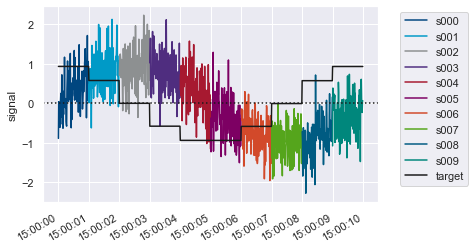

In [7]:
plot_signal(df)
plt.ylabel('signal')
reg_target.signal_x[:1000].plot(color='k', label = 'target')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, linestyle=':', color='k')
plt.savefig('EML02-CSP-regression-problem.pdf')

## Feature Extraction

In [12]:
from tsfresh.feature_extraction import extract_features
from tsfresh.feature_extraction.settings import EfficientFCParameters

X = extract_features(df.iloc[:-1], column_id='window_idx', column_sort='seconds',
                    default_fc_parameters=EfficientFCParameters())
X.shape

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 53.42it/s]


(120, 778)

In [14]:
# drop columns with missing values
X2 = X.dropna(axis=1)
X2.shape

(120, 582)

## Feature Selection for Classification Problem

In [22]:
reg_target

,window_idx,signal_x,seconds,signal_y
2020-09-23 15:00:00.000,s000,0.936441,0.00,1.000000
2020-09-23 15:00:00.010,s000,0.936441,0.01,0.999980
2020-09-23 15:00:00.020,s000,0.936441,0.02,0.999921
2020-09-23 15:00:00.030,s000,0.936441,0.03,0.999822
2020-09-23 15:00:00.040,s000,0.936441,0.04,0.999684
...,...,...,...,...
2020-09-23 15:01:59.950,s119,0.934531,119.95,0.999507
2020-09-23 15:01:59.960,s119,0.934531,119.96,0.999684
2020-09-23 15:01:59.970,s119,0.934531,119.97,0.999822
2020-09-23 15:01:59.980,s119,0.934531,119.98,0.999921


In [25]:
y_reg = reg_target.groupby('window_idx')['signal_y'].mean()

In [26]:
y_reg

window_idx
s000    0.936441
s001    0.580662
s002    0.003090
s003   -0.575662
s004   -0.934531
          ...   
s115   -0.936441
s116   -0.580662
s117   -0.003090
s118    0.575662
s119    0.934531
Name: signal_y, Length: 120, dtype: float64

In [29]:
from tsfresh.transformers import FeatureSelector

In [30]:
select_reg = FeatureSelector(fdr_level=0.5)

select_reg.fit(X2, y_reg)
p_values_reg = pd.Series(select_reg.p_values,
                        index=select_reg.features)
p_values_reg

signal__linear_trend__attr_"slope"                                    7.276657e-32
signal__linear_trend_timewise__attr_"slope"                           7.276657e-32
signal__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"     7.276657e-32
signal__linear_trend__attr_"rvalue"                                   9.514702e-32
signal__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"    9.514702e-32
                                                                          ...     
signal__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"             NaN
signal__ratio_beyond_r_sigma__r_5                                              NaN
signal__ratio_beyond_r_sigma__r_6                                              NaN
signal__ratio_beyond_r_sigma__r_7                                              NaN
signal__ratio_beyond_r_sigma__r_10                                             NaN
Length: 582, dtype: float64

In [38]:
p_values_reg[select_reg.relevant_features].max(), len(select_reg.relevant_features)

(0.005564729525925018, 48)

In [39]:
p_values_reg[select_reg.relevant_features]

signal__linear_trend__attr_"slope"                                     7.276657e-32
signal__linear_trend_timewise__attr_"slope"                            7.276657e-32
signal__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"      7.276657e-32
signal__linear_trend__attr_"rvalue"                                    9.514702e-32
signal__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"mean"     9.514702e-32
signal__linear_trend_timewise__attr_"rvalue"                           9.514702e-32
signal__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"mean"     2.767124e-31
signal__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"mean"     6.462171e-31
signal__agg_linear_trend__attr_"rvalue"__chunk_len_10__f_agg_"mean"    2.966334e-30
signal__fft_coefficient__attr_"imag"__coeff_1                          2.753163e-29
signal__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"max"       1.591791e-26
signal__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"max"      4.391

In [42]:
X2[select_reg.relevant_features].head()

,"signal__linear_trend__attr_""slope""","signal__linear_trend_timewise__attr_""slope""","signal__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","signal__linear_trend__attr_""rvalue""","signal__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","signal__linear_trend_timewise__attr_""rvalue""","signal__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","signal__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","signal__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","signal__fft_coefficient__attr_""imag""__coeff_1",...,"signal__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""imag""__coeff_4","signal__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""angle""__coeff_7","signal__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)",signal__time_reversal_asymmetry_statistic__lag_3,"signal__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""imag""__coeff_8","signal__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","signal__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)"
s000,0.008172,2941.759541,0.040685,0.448293,0.693553,0.448293,0.080526,0.406820,0.785542,9.901143,...,-0.987712,0.181519,-1.037615,162.647261,-1.026525,-0.007583,-1.024652,4.710554,-1.050498,-0.799954
s001,0.003841,1382.928071,0.018682,0.215928,0.407091,0.215928,0.038866,0.250007,0.616639,6.309019,...,0.138490,0.812062,0.302992,-144.478285,0.426640,-0.006363,0.538019,-5.151159,0.644402,-0.243933
s002,0.003214,1157.124947,0.015845,0.178390,0.385640,0.178390,0.031947,0.142985,0.591020,6.668685,...,0.733759,1.710065,0.881594,-126.442363,0.945120,-0.022755,1.041879,-6.798971,1.168699,0.718624
s003,-0.002810,-1011.545321,-0.014072,-0.162657,-0.408695,-0.162657,-0.027620,-0.087975,-0.500074,-2.971181,...,1.027848,-1.153496,1.223327,31.387345,1.372153,0.009074,1.475081,3.307118,1.620111,0.079433
s004,-0.007000,-2520.120402,-0.035026,-0.365600,-0.665810,-0.365600,-0.068274,-0.375910,-0.767296,-10.844074,...,0.393992,3.414602,0.489072,-113.877019,0.650869,0.011882,0.757183,-6.116000,0.836842,-0.036656


In [44]:
select_reg.transform(X2).head()

,"signal__linear_trend__attr_""slope""","signal__linear_trend_timewise__attr_""slope""","signal__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","signal__linear_trend__attr_""rvalue""","signal__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","signal__linear_trend_timewise__attr_""rvalue""","signal__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""","signal__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","signal__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","signal__fft_coefficient__attr_""imag""__coeff_1",...,"signal__cwt_coefficients__coeff_2__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""imag""__coeff_4","signal__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""angle""__coeff_7","signal__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)",signal__time_reversal_asymmetry_statistic__lag_3,"signal__cwt_coefficients__coeff_5__w_20__widths_(2, 5, 10, 20)","signal__fft_coefficient__attr_""imag""__coeff_8","signal__cwt_coefficients__coeff_6__w_20__widths_(2, 5, 10, 20)","signal__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)"
s000,0.008172,2941.759541,0.040685,0.448293,0.693553,0.448293,0.080526,0.406820,0.785542,9.901143,...,-0.987712,0.181519,-1.037615,162.647261,-1.026525,-0.007583,-1.024652,4.710554,-1.050498,-0.799954
s001,0.003841,1382.928071,0.018682,0.215928,0.407091,0.215928,0.038866,0.250007,0.616639,6.309019,...,0.138490,0.812062,0.302992,-144.478285,0.426640,-0.006363,0.538019,-5.151159,0.644402,-0.243933
s002,0.003214,1157.124947,0.015845,0.178390,0.385640,0.178390,0.031947,0.142985,0.591020,6.668685,...,0.733759,1.710065,0.881594,-126.442363,0.945120,-0.022755,1.041879,-6.798971,1.168699,0.718624
s003,-0.002810,-1011.545321,-0.014072,-0.162657,-0.408695,-0.162657,-0.027620,-0.087975,-0.500074,-2.971181,...,1.027848,-1.153496,1.223327,31.387345,1.372153,0.009074,1.475081,3.307118,1.620111,0.079433
s004,-0.007000,-2520.120402,-0.035026,-0.365600,-0.665810,-0.365600,-0.068274,-0.375910,-0.767296,-10.844074,...,0.393992,3.414602,0.489072,-113.877019,0.650869,0.011882,0.757183,-6.116000,0.836842,-0.036656


In [45]:
pd.Series([feature.split('__')[1] for feature in select.relevant_features]).value_counts()

agg_linear_trend             18
fft_coefficient              10
cwt_coefficients              4
linear_trend_timewise         2
linear_trend                  2
first_location_of_maximum     1
first_location_of_minimum     1
last_location_of_minimum      1
mean_change                   1
last_location_of_maximum      1
change_quantiles              1
dtype: int64

In [47]:
efficient_fc = EfficientFCParameters()  
print(efficient_fc['minimum'])

None


In [48]:
efficient_fc['linear_trend']

[{'attr': 'pvalue'},
 {'attr': 'rvalue'},
 {'attr': 'intercept'},
 {'attr': 'slope'},
 {'attr': 'stderr'}]

In [138]:
from tsfresh.feature_extraction.feature_calculators import linear_trend
linear_trend?

In [122]:
from scipy.stats import linregress
linregress?

In [57]:
X2[feature]

s000    0.008172
s001    0.003841
s002    0.003214
s003   -0.002810
s004   -0.007000
          ...   
s115   -0.007220
s116   -0.004017
s117    0.000087
s118    0.005731
s119    0.004321
Name: signal__linear_trend__attr_"slope", Length: 120, dtype: float64

In [59]:
y_reg

window_idx
s000    0.936441
s001    0.580662
s002    0.003090
s003   -0.575662
s004   -0.934531
          ...   
s115   -0.936441
s116   -0.580662
s117   -0.003090
s118    0.575662
s119    0.934531
Name: signal_y, Length: 120, dtype: float64

In [61]:
df

,"signal__linear_trend__attr_""slope""",target
window_idx,,
s000,0.008172,0.936441
s001,0.003841,0.580662
s002,0.003214,0.003090
s003,-0.002810,-0.575662
s004,-0.007000,-0.934531
...,...,...
s115,-0.007220,-0.936441
s116,-0.004017,-0.580662
s117,0.000087,-0.003090


Text(0, 0.5, 'target')

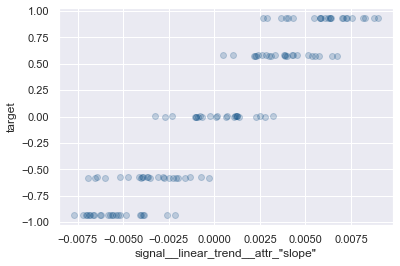

In [65]:
import seaborn as sns

plt.plot(X2[feature], y_reg, 'o', alpha=0.2)
plt.xlabel(feature)
plt.ylabel('target')

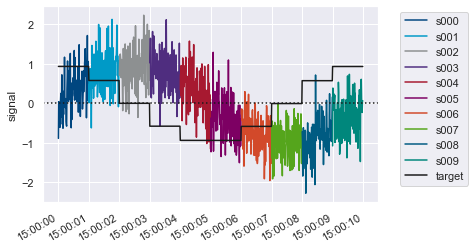

In [137]:
plot_signal(df)
plt.ylabel('signal')
reg_target.signal_x[:1000].plot(color='k', label = 'target')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(0, linestyle=':', color='k')
plt.savefig('EML02-CSP-regression-problem.pdf', bbox_inches='tight')

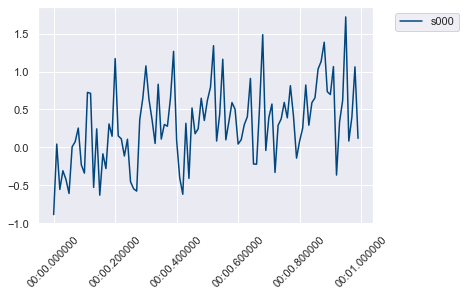

In [72]:
plot_signal(df, n=1)

In [70]:
selection = [feature for feature in X.loc['s000'].index 
             if feature.split('__')[1]=='linear_trend']
selection

['signal__linear_trend__attr_"pvalue"',
 'signal__linear_trend__attr_"rvalue"',
 'signal__linear_trend__attr_"intercept"',
 'signal__linear_trend__attr_"slope"',
 'signal__linear_trend__attr_"stderr"']

In [73]:
X.loc['s000'][selection]

signal__linear_trend__attr_"pvalue"       0.000003
signal__linear_trend__attr_"rvalue"       0.448293
signal__linear_trend__attr_"intercept"   -0.100204
signal__linear_trend__attr_"slope"        0.008172
signal__linear_trend__attr_"stderr"       0.001646
Name: s000, dtype: float64

## Intercept and slope

Text(0, 0.5, 'target')

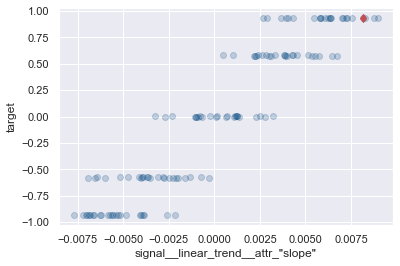

In [123]:
plt.plot(X2[feature], y_reg, 'o', alpha=0.2)
x = X.loc['s000'][selection]['signal__linear_trend__attr_"slope"']
y = y_reg.loc['s000']
plt.plot(x,y, 'rd')
plt.xlabel(feature)
plt.ylabel('target')

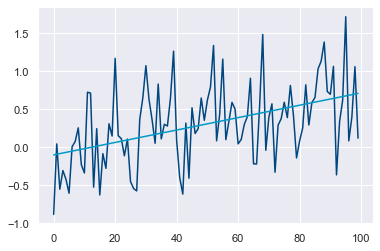

In [124]:
x = np.arange(100)
y = df.signal[df.window_idx=='s000'].values
beta_0 = X.loc['s000']['signal__linear_trend__attr_"intercept"'] 
beta_1 = X.loc['s000']['signal__linear_trend__attr_"slope"']
linear = lambda x: beta_0 + beta_1 * x 

plt.plot(x, y)
#plt.plot(x, y, 'o')
plt.plot(x, linear(x))

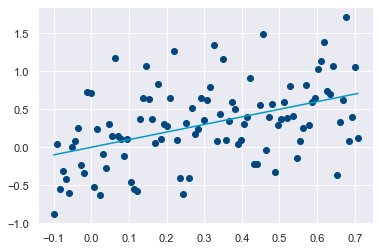

In [125]:
plt.plot(linear(x), y,'o')
y_hat = linear(x)
plt.plot([np.min(y_hat), np.max(y_hat)], [np.min(y_hat), np.max(y_hat)])


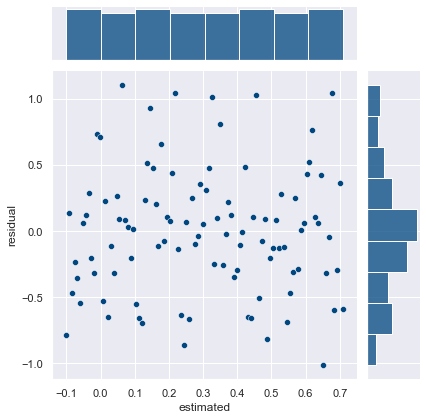

In [126]:
import seaborn as sns
res = pd.DataFrame({'estimated': linear(x),
                   'residual': y-linear(x)})
sns.jointplot('estimated', 'residual', data=res)

In [127]:
std_res = np.std(y-linear(x))
std_res

0.4703405153112487